https://mlcolvar.readthedocs.io/en/latest/notebooks/tutorials/intro_1_training.html

In [ ]:
from mlcolvar.data import DictModule, DictDataset
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights, get_descriptors_and_derivatives, initialize_committor_masses
from mlcolvar.core.transform import PairwiseDistances
from mlcolvar.core.transform.descriptors import CoordinationNumbers
from mlcolvar.core.transform.descriptors import MultipleDescriptors
from mlcolvar.cvs import RegressionCV, AutoEncoderCV, Committor
import torch
import lightning
from lightning import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback
import matplotlib.pyplot as plt
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# number of atoms
n_atoms=2

# temperature in Kelvin
T = 298.15

# simulation cell
cell = torch.Tensor([3.43910, 3.40380, 9.76397])
print('Cell: ', cell)

# Boltzmann factor in the RIGHT ENERGY UNITS!
kb = 0.0083144621 # kJ/mol
beta = 1/(kb*T)

# initialize the masses vector for the calculation
atomic_masses = initialize_committor_masses(atom_types=[0, 1],
                                            masses=[22.98979949951172, 62581.18794512749], # mass of silica slab = 62581.18794512749
                                            n_dims=3)

filenames = ['../unbiased_sims/COLVAR_ub', '../unbiased_sims/COLVAR_b']

load_args = [{'start': 5000, 'stop': 50025, 'stride': 5},
             {'start': 5000, 'stop': 50025, 'stride': 5}]

# load data
dataset, dataframe = create_dataset_from_files(file_names=filenames, create_labels=True, filter_args={'regex': 'psod\.[abc]|pscom\.[abc]'}, return_dataframe=True, load_args=load_args, verbose=True)

# zeroth iteration should be unbiased, we thus initialize the bias as zero
bias = torch.zeros(len(dataset))

# compute weights
dataset = compute_committor_weights(dataset=dataset,
                                    bias=bias,
                                    data_groups=[0, 1],
                                    beta=beta)

# initialize datamodule, SmartDerivatives doesn't support shuffling
datamodule = DictModule(dataset,lengths=[0.8,0.2])

# specify number of nodes per layer (including input and output dimensions)
layers = [6, 32, 32, 1]

# initialize lr scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# create options dictionary
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5},
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.9999 },
            'nn' : {'activation' : 'tanh'}}

model = Committor(layers, options=options, mass=atomic_masses, alpha=1e-1, separate_boundary_dataset=False)

Cell:  tensor([3.4391, 3.4038, 9.7640])
Class 0 dataframe shape:  (9005, 15)
Class 1 dataframe shape:  (9005, 15)

 - Loaded dataframe (18010, 15): ['time', 'ene', 'dis.a', 'dis.b', 'dis.c', 'psod.a', 'psod.b', 'psod.c', 'pscom.a', 'pscom.b', 'pscom.c', 'coord', 'dh', 'walker', 'labels']
 - Descriptors (18010, 6): ['psod.a', 'psod.b', 'psod.c', 'pscom.a', 'pscom.b', 'pscom.c']


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/projectnb/cui-buchem/allenjb/.conda/envs/me508/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /projectnb/cui-buchem/allenjb/me508/pfas_project/unfunctionalized_sod/mlcolvar_committor/modelsave exists and is not empty.

  | Name    | Type           | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | train | ?        | ?        
1 | nn      | FeedForward    | 1.3 K  | train | [1, 6]   | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | train | [1, 1]   | [1, 1]   
--------------------------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10000` reached.


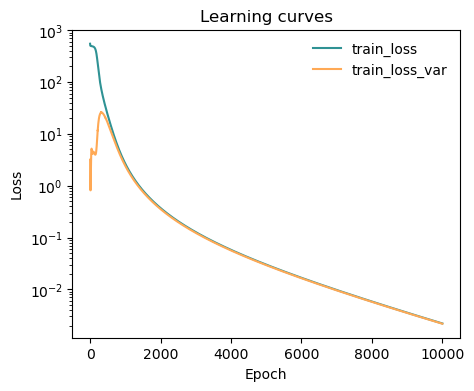

In [2]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights
from lightning.pytorch.callbacks import ModelCheckpoint

# define callbacks
metrics = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath="./modelsave/", save_top_k=10, monitor="train_loss_epoch", every_n_epochs=50)

# initialize trainer, for testing the number of epochs is low, change this to something like 4/5000 at least
trainer = lightning.Trainer(callbacks=[metrics, checkpoint_callback], max_epochs=10000, logger=False, enable_checkpointing=True,
            limit_val_batches=0, num_sanity_val_steps=0, accelerator='cpu'
        )

trainer.fit(model, datamodule)

# plot metrics
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log')

In [3]:
import os

iter = 0

# ensure output directory exists
os.makedirs('models', exist_ok=True)

# turn off preprocessing as in PLUMED we precompute the descriptors to make it faster
model.preprocessing = None

# Provide example input for tracing with correct 2D shape (batch_size=1, n_features)
n_input = layers[0]

# export z model --> activation off
model.sigmoid = None
model.to_torchscript(f'models/model_{iter}_z.pt', method='trace')
#convert_model(f'models/model_{iter}_z.pt', n_input)

# export q model --> activation on
model.sigmoid = torch.nn.Sigmoid()
model.to_torchscript(f'models/model_{iter}_q.pt', method='trace')
#convert_model(f'models/model_{iter}_q.pt', n_input)


Committor(
  original_name=Committor
  (loss_fn): CommittorLoss(original_name=CommittorLoss)
  (nn): FeedForward(
    original_name=FeedForward
    (nn): Sequential(
      original_name=Sequential
      (0): Linear(original_name=Linear)
      (1): Tanh(original_name=Tanh)
      (2): Linear(original_name=Linear)
      (3): Tanh(original_name=Tanh)
      (4): Linear(original_name=Linear)
    )
  )
  (sigmoid): Sigmoid(original_name=Sigmoid)
)

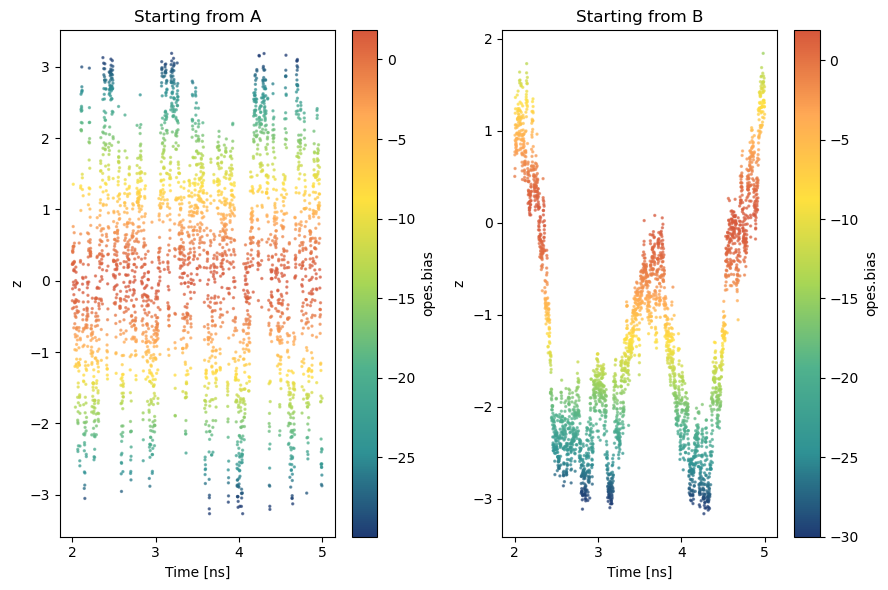

In [14]:
from mlcolvar.utils.io import load_dataframe
import matplotlib.pyplot as plt
from mlcolvar.utils.plot import paletteFessa

from mlcolvar.utils.io import load_dataframe

iter = 6

sampling = load_dataframe([f'biased_sims/iter_{iter}/unbound/COLVAR',
                           f'biased_sims/iter_{iter}/bound/COLVAR'],
                           start=2000)

fig, axs = plt.subplots(1,2,figsize=(9,6))

for i,s in enumerate(['A', 'B']):
    ax = axs[i]
    ax.set_title(f'Starting from {s}')
    ax.set_xlabel('pscom.c')
    ax.set_ylabel('psod.c')

    # temp = sampling[sampling['walker'] == i] # we load one simulation per time
    # cp = ax.scatter(temp['pscom.c'], temp['psod.c'], c=temp['opes.bias'], cmap='fessa',s=2, alpha=0.6)
    # cb = plt.colorbar(cp, ax=ax, label='opes.bias')
    # cb.solids.set(alpha=1)
    temp = sampling[sampling['walker'] == i] # we load one simulation per time
    
    ax = axs[i]
    ax.set_xlabel('Time [ns]')
    ax.set_ylabel('z')
    cp = ax.scatter(temp['time']/1000, temp['z.node-0'], c=temp['opes.bias'], cmap='fessa',s=2, alpha=0.6)
    cb = plt.colorbar(cp, ax=ax, label='opes.bias')
    cb.solids.set(alpha=1)

plt.tight_layout()
plt.show()

# save figure
fig.savefig(f'../figures/iter_{iter}_sampling.png', dpi=300)


In [ ]:
from mlcolvar.data import DictModule, DictDataset
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights, get_descriptors_and_derivatives, initialize_committor_masses
from mlcolvar.core.transform import PairwiseDistances
from mlcolvar.core.transform.descriptors import CoordinationNumbers
from mlcolvar.core.transform.descriptors import MultipleDescriptors
from mlcolvar.cvs import RegressionCV, AutoEncoderCV, Committor
import torch
import lightning
from lightning import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback
import matplotlib.pyplot as plt
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights
from lightning.pytorch.callbacks import ModelCheckpoint

# temperature in Kelvin
T = 298.15

# Boltzmann factor in the RIGHT ENERGY UNITS!
kb = 0.0083144621 # kJ/mol
beta = 1/(kb*T)

# initialize the masses vector for the calculation
atomic_masses = initialize_committor_masses(atom_types=[0, 1],
                                            masses=[22.98979949951172, 62581.18794512749], # mass of silica slab = 62581.18794512749
                                            n_dims=3)

filenames = ['../unbiased_sims/COLVAR_ub',
             '../unbiased_sims/COLVAR_b',
             #'biased_sims/iter_0/unbound/COLVAR',
             #'biased_sims/iter_0/bound/COLVAR',
             #'biased_sims/iter_1/unbound/COLVAR',
             #'biased_sims/iter_1/bound/COLVAR',
            #'biased_sims/iter_2/unbound/COLVAR',
            #'biased_sims/iter_2/bound/COLVAR',
            #'biased_sims/iter_3/unbound/COLVAR',
            #'biased_sims/iter_3/bound/COLVAR',
            #'biased_sims/iter_4/unbound/COLVAR',
            #'biased_sims/iter_4/bound/COLVAR',
            #'biased_sims/iter_5/unbound/COLVAR',
            #'biased_sims/iter_5/bound/COLVAR',
            'biased_sims/iter_6/unbound/COLVAR',
            'biased_sims/iter_6/bound/COLVAR',
            ]

load_args = [{'start': 5000, 'stop': 50025, 'stride': 5},
             {'start': 5000, 'stop': 50025, 'stride': 5},
             {'start' : 2000, 'stop': 5001, 'stride': 1}, # it is wise to discard a first transient part of OPES runs to use converged bias
             {'start' : 2000, 'stop': 5001, 'stride': 1} # it is wise to discard a first transient part of OPES runs to use converged bias

            ]

# load data
dataset, dataframe = create_dataset_from_files(file_names = filenames,
                                               create_labels = True,
                                               filter_args={'regex' : 'psod\.[abc]|pscom\.[abc]'},
                                               return_dataframe = True,
                                               load_args=load_args,
                                               verbose = True)

# get bias
dataframe = dataframe.fillna({'opes.bias': 0, 'bias' : 0})
bias = torch.Tensor(dataframe['opes.bias'].values + dataframe['bias'].values)

# compute weights
dataset = compute_committor_weights(dataset=dataset,
                                    bias=bias,
                                    data_groups=[0, 1, 2, 3],
                                    beta=beta)

datamodule = DictModule(dataset, lengths=[1], shuffle=False, random_split=False)

# specify number of nodes per layer (including input and output dimensions)
layers = [6, 32, 32, 1]

# initialize lr scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# create options dictionary
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5},
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.9999 },
            'nn' : {'activation' : 'tanh'}}

model = Committor(layers, options=options, mass=atomic_masses, alpha=1e-1, separate_boundary_dataset=True)

Class 0 dataframe shape:  (9005, 15)
Class 1 dataframe shape:  (9005, 15)
Class 2 dataframe shape:  (3001, 20)
Class 3 dataframe shape:  (3001, 20)

 - Loaded dataframe (24012, 26): ['time', 'ene', 'dis.a', 'dis.b', 'dis.c', 'psod.a', 'psod.b', 'psod.c', 'pscom.a', 'pscom.b', 'pscom.c', 'coord', 'dh', 'walker', 'labels', 'z.node-0', 'z.bias-0', 'q', 'bias', '@14.bias', '@14.bias_bias', 'opes.bias', 'opes.rct', 'opes.zed', 'opes.neff', 'opes.nker']
 - Descriptors (24012, 6): ['psod.a', 'psod.b', 'psod.c', 'pscom.a', 'pscom.b', 'pscom.c']


/projectnb/cui-buchem/allenjb/.conda/envs/me508/lib/python3.10/site-packages/mlcolvar/data/datamodule.py:133: UserWarning: A torch.generator was provided but it is not used with random_split=False
  warnings.warn(


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/projectnb/cui-buchem/allenjb/.conda/envs/me508/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/projectnb/cui-buchem/allenjb/.conda/envs/me508/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /projectnb/cui-buchem/allenjb/me508/pfas_project/unfunctionalized_sod/mlcolvar_committor/modelsave exists and is not empty.

  | Name    | Type           | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | train | ?        | ?        
1 | nn      | FeedForward    | 1.3 K  | train | [1, 6]   | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | train | [1, 1]   | [1, 1]   
---------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20000` reached.


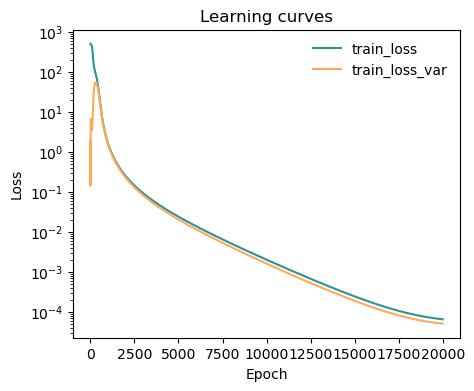

In [8]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights
from lightning.pytorch.callbacks import ModelCheckpoint

#jupyter notebook --NotebookApp.iopub_msg_rate_limit=1.0e10

# define callbacks
metrics = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath="./modelsave/", save_top_k=10, monitor="train_loss_epoch", every_n_epochs=50)

# initialize trainer, for testing the number of epochs is low, change this to something like 4/5000 at least
trainer = lightning.Trainer(callbacks=[metrics, checkpoint_callback], max_epochs=20000, logger=False, enable_checkpointing=True,
            limit_val_batches=0, num_sanity_val_steps=0, accelerator='cpu'
        )

trainer.fit(model, datamodule)

# plot metrics
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log')